In [5]:
# Импорты

import math
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time 

import holidays
import prophet
# from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metrics
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error


In [6]:
from google.oauth2 import service_account

pd.set_option('display.max_columns', 599)
pd.set_option('display.max_rows', 599)

project_id = 'kolesa-android-app'
credentials = 'C:/kolesa-android-app-715adc9bdf26.json'
credentials = service_account.Credentials.from_service_account_file(credentials)

In [7]:
q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""

In [9]:
data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ

C:\Users\lofas\AppData\Local\Temp\ipykernel_4256\3862186898.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ


Downloading: 100%|██████████|


In [ ]:
#ЕСЛИ У ВАС НЕТ ДОСТУПА К BQ, ТО МОЖНО ЗАГРУЗИТЬ ДАННЫЕ ЧЕРЕЗ CSV

# data = pd.read_csv('Data/data.csv')
# data

In [10]:
data.sort_values(by='event_date', inplace=True)
data

,event_date,y
0,2020-01-01,5721
1,2020-01-02,8274
2,2020-01-03,9344
3,2020-01-04,9864
4,2020-01-05,10435
...,...,...
1091,2022-12-27,17042
1092,2022-12-28,16195
1093,2022-12-29,14966
1094,2022-12-30,13070


In [11]:
data.dtypes

event_date    dbdate
y              Int64
dtype: object

In [12]:
data['event_date'] = pd.to_datetime(data['event_date'])
data.dtypes

event_date    datetime64[ns]
y                      Int64
dtype: object

In [13]:
data.columns = ['ds', 'y']
data.index = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


In [14]:
def is_ramadan(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-04-24')) & (date <= pd.to_datetime('2020-05-24'))
            | (date >=pd.to_datetime('2021-04-13')) & (date <= pd.to_datetime('2021-05-13'))
            | (date >=pd.to_datetime('2022-04-03')) & (date <= pd.to_datetime('2022-05-03')))

data['is_ramadan'] = data['ds'].apply(is_ramadan)
data['ramadan'] = data['is_ramadan'].apply(int)
data.head()
    

,ds,y,is_ramadan,ramadan
ds,,,,
2020-01-01,2020-01-01,5721,False,0
2020-01-02,2020-01-02,8274,False,0
2020-01-03,2020-01-03,9344,False,0
2020-01-04,2020-01-04,9864,False,0
2020-01-05,2020-01-05,10435,False,0


In [15]:
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient='index').rename(columns={0: 'holiday'})
df_holidays['ds'] = df_holidays.index
df_holidays.head()

,holiday,ds
2020-01-01,New Year,2020-01-01
2020-01-02,New Year,2020-01-02
2020-01-07,Orthodox Christmas,2020-01-07
2020-03-08,International Women's Day,2020-03-08
2020-03-22,Nauryz holiday,2020-03-22


<Axes: xlabel='ds'>

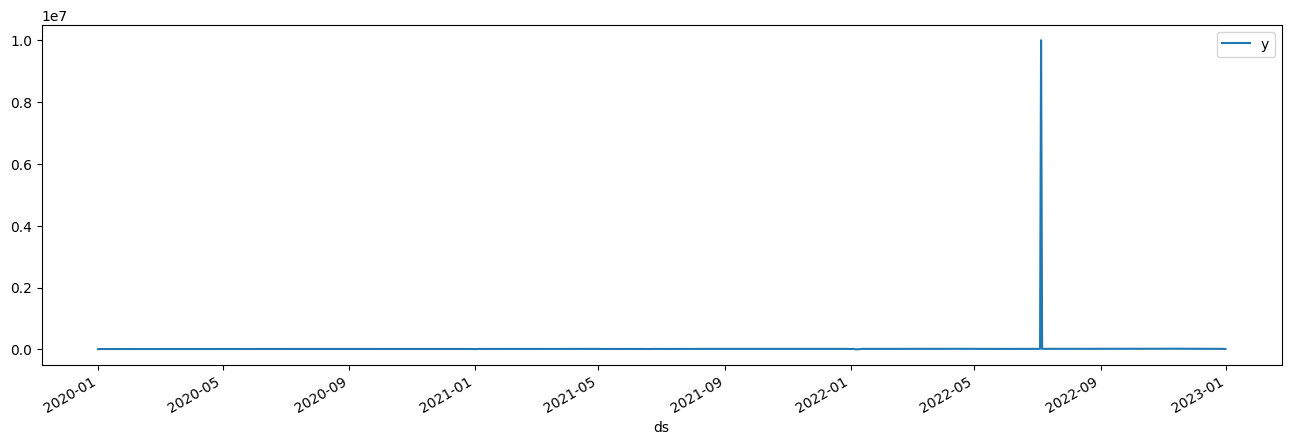

In [20]:
data.plot(x = 'ds', y = 'y', kind='line', figsize=(16, 5))

In [16]:
def get_mape(model, actual=data):
    return mean_absolute_percentage_error(actual['y'], model.predict(actual)['yhat'])

def plot(model, actual=data, threshold_changepoints=0.01):
    df_pred = model.predict(actual)
    df_pred.index = df_pred.ds
    df_plot = pd.concat([actual, df_pred], axis=1)
    ax = df_plot[:].plot(y=["y", "yhat"], kind = "line", figsize=(10, 10))
    a = add_changepoints_to_plot(ax, model, df_pred, threshold = threshold_changepoints)

In [17]:
initial = str(int(data.shape[0]/2)) + ' days'
horizon = str(int(data.shape[0]/20)) + ' days'
period = str(int(data.shape[0]/20)) + ' days'
print('initial:', initial) 
print('horizon:', horizon)
print('period:', period)

initial: 548 days
horizon: 54 days
period: 54 days


03:22:43 - cmdstanpy - INFO - Chain [1] start processing
03:22:43 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 3.1474858448889957)

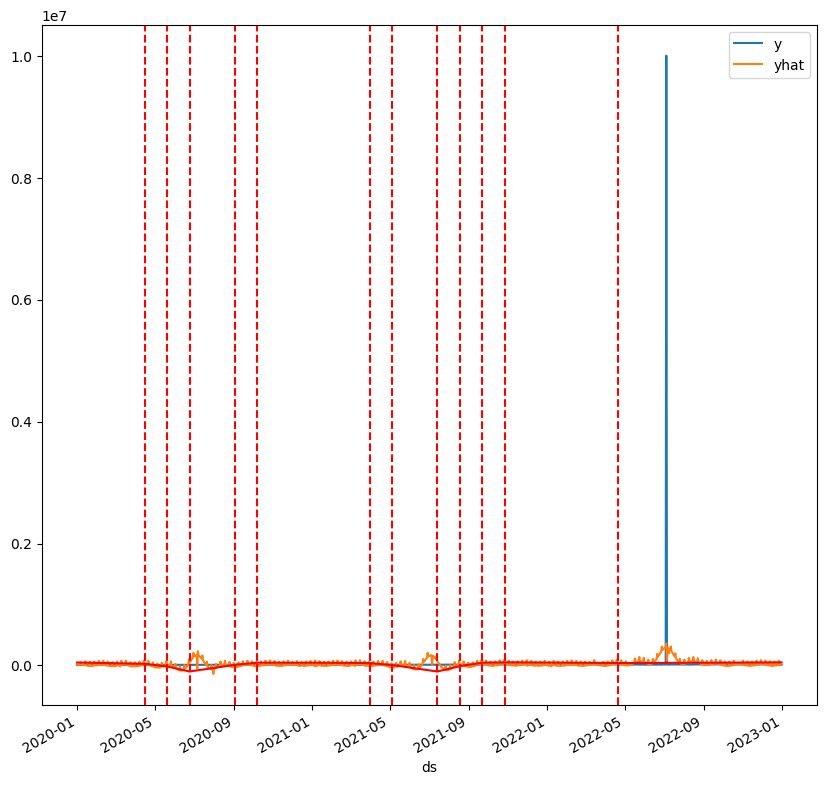

In [19]:
model = Prophet(changepoint_prior_scale=0.9, holidays = df_holidays)

# with suppress_stdout_stderr():
model.fit(data)

cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)